In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 18,
        'serif'  : 'New Century Schoolbook'}
rc('font', **font)
import numpy as np

In [2]:
from pyke import SimpleKeplerPRF, PRFPhotometry, SceneModel
from pyke.lightcurve import KeplerLightCurveFile, LightCurve
from pyke import KeplerTargetPixelFile
from pyke.utils import KeplerQualityFlags
from oktopus import UniformPrior

/Users/jvmirca/dev/PyKE/pyke/__init__.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.insta

In [3]:
tpf = KeplerTargetPixelFile("https://archive.stsci.edu/missions/k2/target_pixel_files/c91/"
                            "224400000/32000/ktwo224432562-c91_lpd-targ.fits.gz",
                            quality_bitmask=2096639)

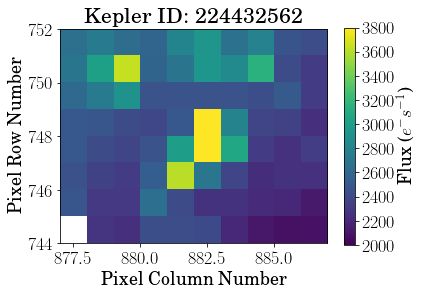

In [4]:
tpf.plot(frame=1, vmin=2000, vmax=3800)
#plt.savefig('tpf_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

In [6]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [7]:
scene = SceneModel(prfs=5*[prf])

In [8]:
# define priors for flux, column, row
prior = UniformPrior(lb=[1e2, 880, 745, 1e2, 881, 746, 1e2, 878, 749, 1e2, 883.5, 749, 1e2, 881, 749, 0],
                     ub=[5e3, 883, 748, 12e3, 884, 750, 5e3, 881, 752, 5e3, 886, 752, 5e3, 884, 752, 4.6e3])

Text(0.5,1,'PSF Models')

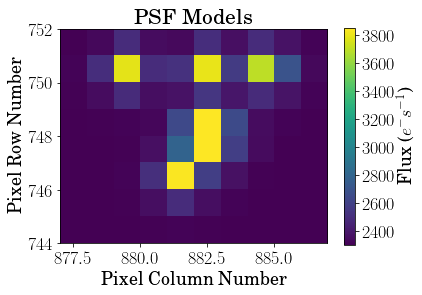

In [9]:
scene.plot(*prior.mean)
plt.title('PSF Models')

In [10]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [11]:
results = phot.fit(tpf.flux, options={'ftol':1e-12, 'xtol':1e-6, 'maxfev':2000})

  0%|          | 0/1205 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  4%|▎         | 43/1205 [00:31<14:01,  1.38it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
100%|██████████| 1205/1205 [14:47<00:00,  1.36it/s]


In [12]:
residuals = phot.get_residuals()

In [13]:
flux1 = results[:, 0]
xc1 = results[:, 1]
yc1 = results[:, 2]
flux2 = results[:, 3]
xc2 = results[:, 4]
yc2 = results[:, 5]
flux3 = results[:, 6]
xc3 = results[:, 7]
yc3 = results[:, 8]
flux4 = results[:, 9]
xc4 = results[:, 10]
yc4 = results[:, 11]
flux5 = results[:, 12]
xc5 = results[:, 13]
yc5 = results[:, 14]
bkg = results[:, -1]

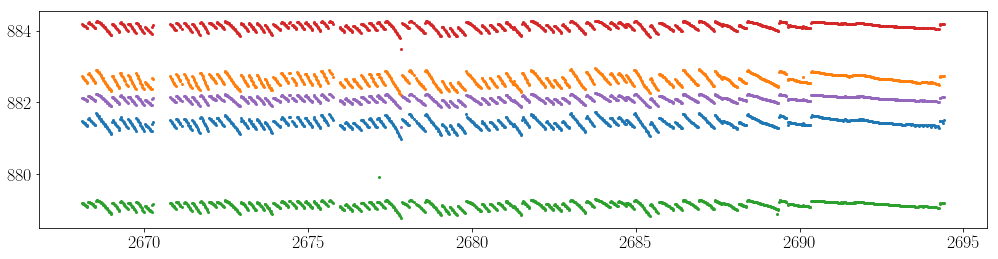

In [17]:
plt.figure(figsize=[17, 4])
for xc in [xc1, xc2, xc3, xc4, xc5]:
    plt.plot(tpf.time, xc, 'o', markersize=2)

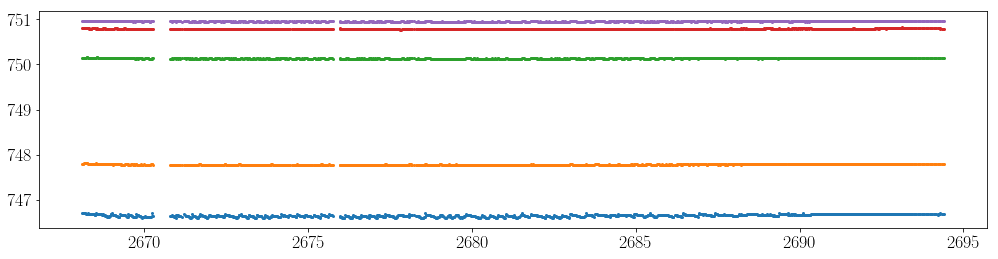

In [18]:
plt.figure(figsize=[17, 4])
for yc in [yc1, yc2, yc3, yc4, yc5]:
    plt.plot(tpf.time, yc, 'o', markersize=2)

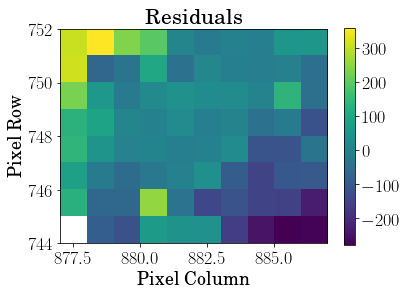

In [20]:
plt.imshow(residuals[0], origin='lower', extent=(877, 887, 744, 752))
plt.title("Residuals")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
cbar = plt.colorbar()
cbar.ax.set_label(r"Flux $(e^{-}s^{-1})$")
#plt.savefig('residuals_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

In [16]:
# Percentual error in the two most bright pixels
100 * residuals[1][4:6, 6]/tpf.flux[1][4:6, 6]

array([ 0.3392684 ,  1.30776026])

In [21]:
prf1 = [prf(flux1[i], xc1[i], yc1[i]) for i in range(len(tpf.time))]

In [22]:
prf2 = [prf(flux2[i], xc2[i], yc2[i]) for i in range(len(tpf.time))]

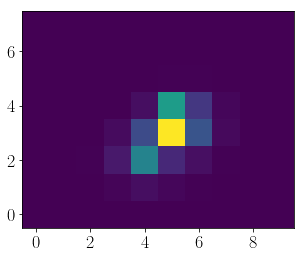

In [23]:
plt.imshow(prf1[0] + prf2[0], origin='lower')

In [24]:
from astropy.io import fits as pyfits

In [25]:
# after detrending with k2sc
f = pyfits.open("EPIC_star224432562_amc2.fits")
ff = flux2 - f[1].data['trend_p_1'] + np.median(f[1].data['trend_p_1'])

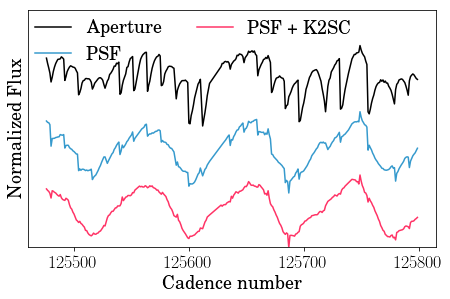

In [26]:
plt.figure(figsize=[7, 4.5])
plt.plot(tpf.cadenceno[200:500], .13 + apr_lc[200:500]/np.median(apr_lc[200:500]), color='k', label='Aperture')
plt.plot(tpf.cadenceno[200:500], -0.05 + flux2[200:500]/np.median(flux2[200:500]), color='#369acd', label='PSF')
plt.plot(tpf.cadenceno[200:500], -.2 + ff[200:500]/np.median(ff[200:500]), color='#ff3366', label='PSF + K2SC')
plt.xlabel("Cadence number")
plt.ylabel("Normalized Flux")
plt.legend(loc=(.0,.75), frameon=False, ncol=2)
plt.tight_layout()
plt.ylim(0.7, 1.3)
plt.yticks([], [])
plt.savefig('lc_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

Text(0.5,1,'Fitted Model')

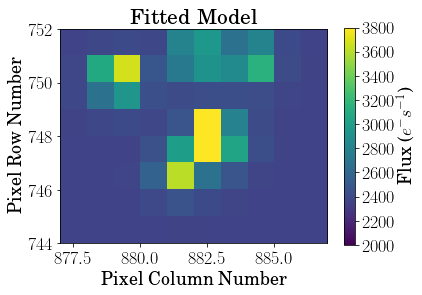

In [27]:
scene.plot(*phot.opt_params[1], vmin=2000, vmax=3800)
plt.title('Fitted Model')
#plt.savefig('model_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)